## EXERCISE 0

Download and extract the Python version of the CIFAR dataset from the CIFAR website.  
The dataset is structured as follows:

- **5 training batches** of 10,000 images each (50,000 images total)  
- **1 test batch** of 10,000 images  

Each batch file contains a **dictionary** with the following elements:

- **`data`** – a 10,000 × 3,072 NumPy array of `uint8`.  
  Each row represents a 32×32 color image:  
  - The first 1,024 entries are the red channel,  
  - The next 1,024 entries are the green channel,  
  - The final 1,024 entries are the blue channel.  
  Images are stored in **row-major order**, i.e., the first 32 entries correspond to the red values of the first row of the image.

- **`labels`** – a list of 10,000 integers in the range 0–9.  
  The number at index `i` indicates the label of the `i`th image in `data`.

The dataset also contains another file called **`batches.meta`**, which is a Python dictionary with the following entry:

- **`label_names`** – a 10-element list giving meaningful names to the numeric labels in the `labels` array described above.  
  For example:  
  ```python
  label_names[0] == "airplane"
  label_names[1] == "automobile"
  # etc.


Number of training samples: 50000
Image shape: torch.Size([3, 32, 32]) Label: 6


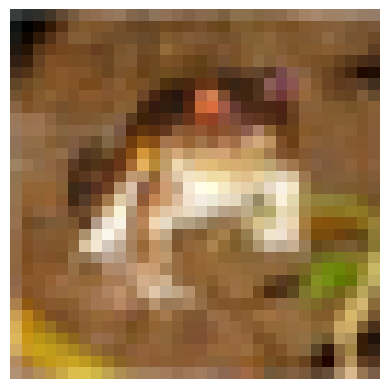

Label: 6


In [1]:
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class CIFAR10Dataset(Dataset):
    def __init__(self, path, data_type='train', transform=None):
        """
        Args:
            path (str): path to the CIFAR-10 data files
            data_type (str): 'train' or 'test'
            transform (callable, optional): transformation to apply to each image
        """
        self.path = path
        self.transform = transform
        self.data = []
        self.labels = []

        if data_type == 'train':
            # load all 5 training batches
            for i in range(1, 6):
                file = f"{path}/data_batch_{i}"
                with open(file, 'rb') as fo:
                    batch = pickle.load(fo, encoding='bytes')
                    # reshape to (10000,3,32,32)
                    imgs = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                    self.data.append(imgs)
                    self.labels += batch[b'labels']
            self.data = np.vstack(self.data)  # shape (50000,3,32,32)
        elif data_type == 'test':
            file = f"{path}/test_batch"
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')
                self.data = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                self.labels = batch[b'labels']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # CHW
        label = self.labels[idx]

        # Convert CHW -> HWC for ToTensor
        img = np.transpose(img, (1, 2, 0))

        # Apply transformation if provided
        if self.transform:
            img = self.transform(img)

        return img, label

    def visualize(self, img):
        """Visualize a single image (tensor or NumPy array)."""
        if isinstance(img, torch.Tensor):
            img = img.clone().detach()
            img = img.numpy()
            img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
            img = img * 0.5 + 0.5  # denormalize
        elif img.max() > 1.0:
            img = img / 255.0  # normalize if uint8

        plt.imshow(img)
        plt.axis('off')
        plt.show()


# ------------------------------
# Main: Instantiate and test
# ------------------------------

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # converts HWC uint8 image to CHW float tensor [0,1]
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # normalize to [-1,1]
])

# Load the dataset
dataset = CIFAR10Dataset(path='data', data_type='train', transform=transform)

# Check dataset size
print("Number of training samples:", len(dataset))

# Get one sample
img, label = dataset[0]
print("Image shape:", img.shape, "Label:", label)

# Visualize first 5 images
for i in range(1):
    img, label = dataset[i]
    dataset.visualize(img)
    print("Label:", label)


## **EXERCISE 2** 
Build a CNN model to predict a class from the input image (you can use
the Conv2D module and one of the plenty pooling layers already implemented).

Which are the main hyperparameters you should set to build the main model?

Good practice is to build the model class as general as possible, and specify the
hyperparaemeters when the class is called.

#### **Explanation**

In the follwing code there is implemented a general convolutional neural network (CNN) that mimics the standard CNN pipeline studied in class:

Convolution → Activation → Pooling → Flatten → Fully connected → Output.


#### **Exercise E2 – Building a General CNN Explanation**

This model defines a <strong>flexible CNN architecture</strong> that can later be configured with
specific hyperparameters (for Exercise E3). It follows exactly the theory from the Convolutional Neural Network lecture.</p>

#### **Main components:**

- <strong>Convolution layers</strong>: learn feature detectors that extract edges, textures, and shapes.
- <strong>Activation (ReLU)</strong>: introduces non-linearity, letting the model learn complex features.
- <strong>Pooling</strong>: reduces spatial size, making the network more robust to position changes.
- <strong>Flattening</strong>: converts 3D feature maps into a 1D vector.
- <strong>Fully Connected layers</strong>: perform the classification using learned features.


#### **Main hyperparameters to specify:**

- Number of convolutional layers and filters
- Kernel size of each convolution
- Pooling type (max or average), kernel, and stride
- Number of neurons in fully connected layers
- Number of output classes

#### **Good practice:**
The model class is <strong>general</strong>: all hyperparameters can be set when the class is called,
and the fully connected layers are created automatically based on the input size. This ensures reusability and avoids hardcoding.</p>




### **Which main hyperparameters must we set?**

1. **Convolutional hyperparameters:**

- conv1_channels, conv2_channels — number of filters in each conv layer (controls model capacity / feature depth). Lecture: depth equals number of filters. 

- kernel_size — the size of each filter (e.g., 5 means 5×5). Larger kernel → bigger receptive field (detects larger patterns). 

- padding and stride — used to control output size and sampling.

2. **Pooling hyperparameters**

- pool_type — 'avg' or 'max' (lecture explains both). Max is common for feature preservation; average sometimes used where smoothing is desirable. 

- pool_kernel & pool_stride — window size and stride for downsampling (lecture: pooling has these hyperparameters). 

3. **Fully connected hyperparameters**

- fc_spatial (Approach A) or fc1_units, fc2_units — number of neurons in FC layers (controls classifier capacity). The lecture mentions designing FC layers after flattening. 

4. **Other general choices**

- num_classes — target number of classes (here CIFAR-10 → 10).

- Activation choice — ReLU is standard and recommended in lecture. 

These are all exposed as __init__ arguments in the model classes above, so I can instantiate many variants without changing the class body.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class GeneralCNN(nn.Module):
    
    def __init__(self, 
                 in_channels=3, 
                 num_classes=10, 
                 conv_layers=[(6, 5), (16, 5)], 
                 pool_type='max',
                 pool_kernel=2,
                 pool_stride=2,
                 fc_layers=[120, 84],
                 activation='relu'): 
        """
        A general CNN model structure for image classification tasks.
        """
        super(GeneralCNN, self).__init__()

        # Salviamo la funzione di attivazione come attributo
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        else:
            raise ValueError("Unsupported activation function")
        
        self.layers = nn.ModuleList()
        current_channels = in_channels

        # Costruzione dei layer convoluzionali
        for out_channels, kernel_size in conv_layers:
            conv = nn.Conv2d(current_channels, out_channels, kernel_size=kernel_size)
            self.layers.append(conv)
            current_channels = out_channels

        # Pooling
        if pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        elif pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)
        else:
            raise ValueError("pool_type must be 'max' or 'avg'")

        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        self.fc_config = fc_layers
        self.num_classes = num_classes

        # L’inizializzazione dei fully connected layer verrà fatta nel forward
        # dopo aver conosciuto la dimensione flatten


    ## This defines the fully connected layers, because their input size depends on the output size of the convolution+pooling part.
    def build_fc_layers(self, flattened_size): #method that creates the layers dynamically the first time the model runs
        """Define fully connected layers once flattened size is known."""
        layers = []
        input_size = flattened_size
        for units in self.fc_config:
            layers.append(nn.Linear(input_size, units))
            input_size = units
        layers.append(nn.Linear(input_size, self.num_classes))
        self.fc_layers = nn.ModuleList(layers)
        #print(f"Building FC layers with input size {flattened_size}")



    ## Called every time you call the model with data (model(x)):
    # Applies the operations defined in __init__ (and those added in build_fc_layers) to the input data — in the correct sequence.
    def forward(self, x):
        #print("Starting forward pass...")

        # Apply convolutional layers
        for conv in self.layers:
            #print(f"Input to conv: {x.shape}")
            x = conv(x)
            x = self.activation(x)
            if self.pool: 
                x = self.pool(x)
            #print(f"After pooling: {x.shape}")

        # Flatten
        x = torch.flatten(x, 1)
        #print(f"After flatten: {x.shape}")

        # If FC layers not yet built (first forward), build them dynamically
        if not self.fc_layers:
            #print("FC layers not built yet — building them now!")
            self.build_fc_layers(x.shape[1])  # definisci i fully connected layer

        # Pass through fully connected layers
        for i, fc in enumerate(self.fc_layers):
            #print(f"Passing through FC layer {i+1}")
            if i < len(self.fc_layers) - 1:  # all but last layer
                x = self.activation(fc(x))  # <-- usa self.activation
            else:
                x = fc(x)  # last layer = output layer (no activation)

        #print("Forward pass done.")
        return x


REAL DATA MAIN

conda install -c conda-forge ipywidgets; 
conda install tqdm


In [ ]:
# 1. Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

# Assuming CIFAR10Dataset and GeneralCNN are already defined above

# 2. Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# 3. Dataset
train_dataset = CIFAR10Dataset(path='data', data_type='train', transform=transform)
test_dataset = CIFAR10Dataset(path='data', data_type='test', transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Model
model = GeneralCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 5. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 6. Training loop with progress bars
num_epochs = 15

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    running_loss = 0.0
    
    batch_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Batches", leave=False)
    for i, (images, labels) in enumerate(batch_loop):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # Update batch progress bar with current average loss
        batch_loop.set_postfix({"loss": running_loss / (i+1)})
    
print(f"loss function: {running_loss}")

print("Training finished!")


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/10 Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/10 Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4/10 Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5/10 Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6/10 Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7/10 Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8/10 Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9/10 Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10/10 Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Training finished!


Overall Test Accuracy: 0.1743
              precision    recall  f1-score   support

           0     0.1642    0.0110    0.0206      1000
           1     0.1636    0.0180    0.0324      1000
           2     0.0000    0.0000    0.0000      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.0909    0.0010    0.0020      1000
           5     0.3333    0.0020    0.0040      1000
           6     0.1457    0.9530    0.2528      1000
           7     0.0000    0.0000    0.0000      1000
           8     0.2205    0.6460    0.3288      1000
           9     0.3323    0.1120    0.1675      1000

    accuracy                         0.1743     10000
   macro avg     0.1451    0.1743    0.0808     10000
weighted avg     0.1451    0.1743    0.0808     10000

Mean ROC AUC: 0.6371


/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


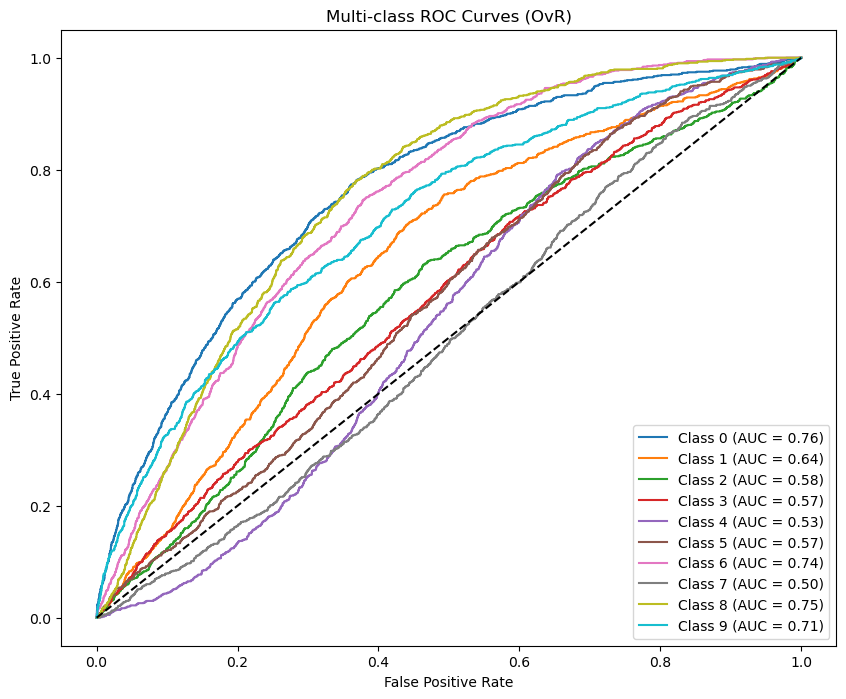

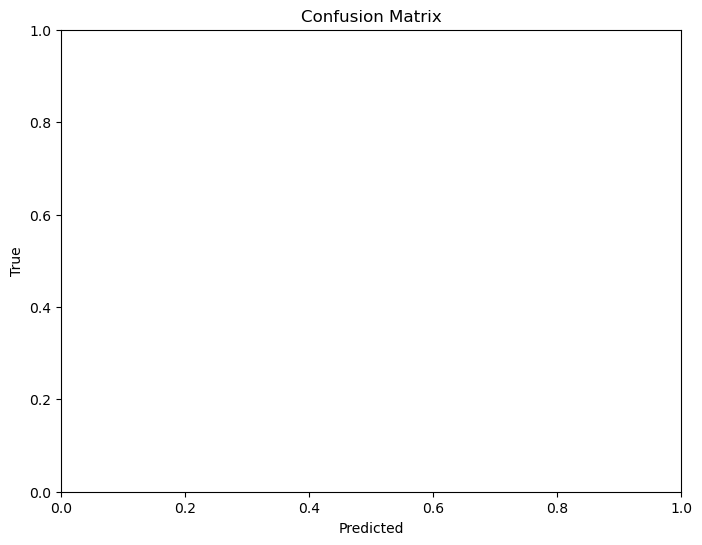

In [4]:
# -----------------------------
# Evaluation
# -----------------------------

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize
#import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_preds.append(probs.cpu())
        all_labels.append(labels)

all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Accuracy
pred_classes = all_preds.argmax(axis=1)
accuracy = accuracy_score(all_labels, pred_classes)
print(f"Overall Test Accuracy: {accuracy:.4f}")

# Per-class precision, recall, f1
print(classification_report(all_labels, pred_classes, digits=4))

# Mean ROC AUC (one-vs-rest)
n_classes = 10
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))
roc_auc = roc_auc_score(all_labels_bin, all_preds, multi_class='ovr')
print(f"Mean ROC AUC: {roc_auc:.4f}")


# Optional: plot ROC curves for each class
plt.figure(figsize=(10,8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr,tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves (OvR)')
plt.legend(loc='lower right')
plt.show()

# Optional: Confusion matrix
cm = confusion_matrix(all_labels, pred_classes)
plt.figure(figsize=(8,6))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [5]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")


Total trainable parameters: 62006
